# Climate Indicators for Europe

This dataset contains climate data derived from reanalysis and model simulations and is available in the Copernicus Climate Data Store (CDS). It provides climate indices describing the impacts of climate variability and change on sectors such as health, agriculture, energy and water management. These indices are important for adaptation planning at European and national level and were developed by the European Environment Agency (EEA) to meet the needs of national climate adaptation initiatives in the EU.

The indices are based on data from different CDS datasets and include temperature, precipitation and wind indicators. They were calculated from the datasets “Climate and energy indicators for Europe from 2005 to 2100” and “ERA5 hourly data on single levels from 1940 to present”. Other indices come from CDS thematic projects.

**Information on Dataset:**
* Source: [Climate Indicators](https://cds.climate.copernicus.eu/datasets/sis-ecde-climate-indicators?tab=overview)
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.2 (Updated: December 13, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\climate-indicators\download"
working_folder = r".\data\climate-indicators\working"
geotiff_folder = r".\data\climate-indicators\geotiff"
csv_folder = r".\data\climate-indicators\csv"
output_folder = r".\data\climate-indicators\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

Define additional request fields to ensure the request stays within the file size limit. When working with geospatial data or APIs that return map or satellite imagery, limiting the geographical area of interest can prevent overly large requests that exceed file size or processing limits. Bounding boxes are used to define
the geographic area for such requests.

The coordinates below were obtained using the <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> tool.

*BBox Extractor is a web-based tool that helps users interactively select and generate bounding box coordinates in WGS84 format (latitude/longitude). This is especially useful when working with APIs or datasets that require a geographic area input.*

In [3]:
# Define the bounding box coordinates (WGS84 format)
# The coordinates are in the format: [North, West, South, East]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

In [4]:
# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Load the shapefile of Konstanz (WGS84 projection) for geographic boundary filtering
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extract the bounding box of the shapefile
de_bounds = de_gdf.total_bounds

# Adjust and buffer the bounding box to create a slightly larger
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Rearrange the coordinates to the format: [North, West, South, East]
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [5]:
# Case I: Requirement is defined for Origin: Projections
# Variables are selected from the ‘Heat and cold’ and ‘Wet and dry’ variable groups.

dataset = "sis-ecde-climate-indicators"
request_rea= {
    "variable": [
        "growing_degree_days",
        "heating_degree_days",
        "cooling_degree_days",
        "tropical_nights",
        "hot_days",
        "warmest_three_day_period",
        "heatwave_days",
        "high_utci_days",
        "frost_days",
        "total_precipitation",
        "maximum_consecutive_five_day_precipitation",
        "extreme_precipitation_total",
        "frequency_of_extreme_precipitation",
        "consecutive_dry_days",
        "duration_of_meteorological_droughts",
        "magnitude_of_meteorological_droughts",
        "days_with_high_fire_danger",
        "extreme_wind_speed_days",
        "fire_weather_index"
    ],
    "origin": "reanalysis",
    "temporal_aggregation": ["yearly"],
    "spatial_aggregation": "gridded",
    "other_parameters": [
        "30_c",
        "35_c",
        "40_c"
    ],
    "area": bbox_de_bounds_adjusted
}

In [6]:
# Case II: Enquiry is defined for Origin: Projections
# Variables are selected from the ‘Heat and cold’ and ‘Wet and dry’ variable groups.

dataset = "sis-ecde-climate-indicators"
request_proj = {
    "variable": [
        "growing_degree_days",
        "heating_degree_days",
        "cooling_degree_days",
        "tropical_nights",
        "hot_days",
        "warmest_three_day_period",
        "heatwave_days",
        "frost_days",
        "total_precipitation",
        "maximum_consecutive_five_day_precipitation",
        "extreme_precipitation_total",
        "frequency_of_extreme_precipitation",
        "consecutive_dry_days",
        "duration_of_meteorological_droughts",
        "magnitude_of_meteorological_droughts",
        "days_with_high_fire_danger",
        "extreme_wind_speed_days",
        "fire_weather_index"
    ],
    "origin": "projections",
    "gcm": ["mpi_esm_lr"],
    "rcm": ["cclm4_8_17"],
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_member": ["r1i1p1"],
    "temporal_aggregation": ["yearly"],
    "spatial_aggregation": "gridded",
    "other_parameters": [
        "30_c",
        "35_c",
        "40_c"
    ],
    "area": bbox_de_bounds_adjusted
}

In [7]:
# Run this cell to download the dataset:
def main_retrieve():
    for request in [request_rea, request_proj]:
        dataset_filename = f"{dataset}_{request['origin']}_{request['temporal_aggregation'][0]}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
        if not os.path.isfile(dataset_filepath):
            # Call the CDS client only if the dataset has not been downloaded before
            client = main()
            # Download the dataset with the defined request parameters
            client.retrieve(dataset, request, dataset_filepath)
        else:
            print("Dataset already downloaded.")
        
if __name__ == "__main__":
    main_retrieve()

Dataset already downloaded.
Dataset already downloaded.


### 2.3 Extract the ZIP file in folder

In [8]:
import zipfile

for request in [request_rea, request_proj]:
    # Define the folder in which the extracted files are saved
    dataset_filename = f"{dataset}_{request['origin']}_{request['temporal_aggregation'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    extract_folder = os.path.join(working_folder, f"{request['origin']}_{request['temporal_aggregation'][0]}")
    os.makedirs(extract_folder, exist_ok=True)

    # Extract the ZIP file only if the folder is empty
    try:
        if not os.listdir(extract_folder):
            # Attempt to open and extract the ZIP file
            with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
                print(f"Successfully extracted files to: {extract_folder}")
        else:
            print("Folder is not empty. Skipping extraction.")
    except FileNotFoundError:
        print(f"Error: The file {dataset_filepath} was not found.")
    except zipfile.BadZipFile:
        print(f"Error: The file {dataset_filepath} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.
Folder is not empty. Skipping extraction.


## 3. Investigate the Metadata of the NetCDF4 file

In [9]:
# Define the origin of the data, either "projections"" or "reanalysis"
origin = "reanalysis"

# Create the path to the folder in which the extracted data is saved
extract_folder = os.path.join(working_folder, f"{origin}_{request['temporal_aggregation'][0]}")

### 3.1 Create a Dataframe of Available NetCDF Files

In [ ]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    # Match the filename against the expected pattern
    match = re.search(r"(?P<index>\w+?)_(?P<ds_variable>[a-zA-Z_]+?)-(?P<ds_origin>\w+?)-(?P<ds_temporal_aggregation>\w+)(?:-(?P<ds_stat>min|max|mean))?(?:-(?P<ds_grid>\d+deg))?(?:-(?P<ds_rcp>rcp_\d+_\d+))?",filename)

    # Raise an error if the filename doesn't match the expected pattern
    if not match:
        raise ValueError("The given filename does not fit the expected naming scheme.")

    # Function to extract the variable name from the NetCDF file
    def get_nc_variable():
        with nc.Dataset(os.path.join(extract_folder, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][0]

    # Return metadata as a dictionary
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        # index=match.group('index'),
        ds_variable=match.group('ds_variable'),
        ds_origin=match.group('ds_origin'),
        ds_temporal_aggregation=match.group('ds_temporal_aggregation'),
        # ds_stat=match.group('ds_stat'),
        variable_name=get_nc_variable(),
        ds_grid=match.group('ds_grid'),
        ds_rcp=match.group('ds_rcp')
    )

# Extract metadata for all NetCDF files in the folder
# The nc_files is a dictionary that contains all the relavent metadata of availabe netcdf4 files
# This dictionary is later used to convert to GeoTiff files
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Modify pandas display options
pd.options.display.max_colwidth = 24

# Display the DataFrame without displaying the 'path' column
df_nc_files.head(10).loc[:, df_nc_files.columns != 'path']

,filename,ds_variable,ds_origin,ds_temporal_aggregation,variable_name,ds_grid,ds_rcp
0,02_growing_degree_da...,growing_degree_days,reanalysis,yearly,t2m,None,None
1,03_heating_degree_da...,heating_degree_days,reanalysis,yearly,data,None,None
2,04_cooling_degree_da...,cooling_degree_days,reanalysis,yearly,data,None,None
3,05_tropical_nights-r...,tropical_nights,reanalysis,yearly,t2m,None,None
4,06_hot_days-reanalys...,hot_days,reanalysis,yearly,t2m,30deg,None
5,06_hot_days-reanalys...,hot_days,reanalysis,yearly,t2m,35deg,None
6,06_hot_days-reanalys...,hot_days,reanalysis,yearly,t2m,40deg,None
7,07_warmest_three_day...,warmest_three_day_pe...,reanalysis,yearly,t2m,None,None
8,09_heat_waves_climat...,heat_waves_climatolo...,reanalysis,yearly,data,None,None
9,10_high_utci_days-re...,high_utci_days,reanalysis,yearly,high_utci_days,None,None


### 3.2 Print unique Variable name(s) and Available Variables

In [11]:
# Define variable to keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variables in each NetCDF file
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # List all variables in the current dataset
        variables_list = list(nc_dataset.variables.keys())
        
        # Print details of the file and its variables
        print(f"{i + 1:<2} {variable_name:<18}: Available variables: {variables_list}")
    
    # Mark this variable as seen
    seen_variables.add(variable_name)

1  t2m               : Available variables: ['t2m', 'time', 'realization', 'lat', 'lon']
2  data              : Available variables: ['data', 'time', 'realization', 'lat', 'lon']
10 high_utci_days    : Available variables: ['high_utci_days', 'time', 'height', 'lon', 'lat']
12 tp                : Available variables: ['tp', 'time', 'realization', 'lat', 'lon']
16 cdd               : Available variables: ['cdd', 'realization', 'lat', 'lon', 'time']
17 dmd               : Available variables: ['dmd', 'lat', 'lon', 'realization', 'time']
19 fwi               : Available variables: ['fwi', 'time', 'lon', 'lat']


In [ ]:
# Define variable to keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variable information in each NetCDF file  
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Access the primary variable data
        variable_data = nc_dataset[variable_name]  

        # Generate a summary of the primary variable
        summary = {  
            "Variablen Name": variable_name,  
            "Data Type": variable_data.dtype,  
            "Shape": variable_data.shape,  
            "Variable Info (Dimensions)": f"{variable_data.dimensions}",
            "Units": getattr(variable_data, "units", "N/A"),
            "Long Name": getattr(variable_data, "long_name", "N/A"),
        }  

        # Display dataset summary as a DataFrame for better visualization
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])
        print(f"{i + 1}. Summary of Variable '{variable_name}':")
        display(nc_summary)

    # Add the variable name to the seen set
    seen_variables.add(variable_name)  

    # Limit output
    output_limit = 2  
    if len(seen_variables) >= output_limit:  
        print(f".... (Output truncated to first {output_limit} variables)")
        break

1. Summary of Variable 't2m':


,Description,Remarks
0,Variablen Name,t2m
1,Data Type,float32
2,Shape,"(84, 32, 38)"
3,Variable Info (Dimen...,"('time', 'lat', 'lon')"
4,Units,1
5,Long Name,N/A


2. Summary of Variable 'data':


,Description,Remarks
0,Variablen Name,data
1,Data Type,float32
2,Shape,"(84, 32, 38)"
3,Variable Info (Dimen...,"('time', 'lat', 'lon')"
4,Units,K
5,Long Name,N/A


.... (Output truncated to first 2 variables)


## 4. Export the NetCDF4 files in CSV format

### 4.1 Define a Function to convert NetCDF data to a DataFrame

In [ ]:
import xarray as xr

# Function for converting NetCDF data into a Pandas DataFrame
def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):

    # Open the NetCDF Dataset in read mode
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Access the variable data from the dataset
        variable_data = nc_dataset[nc_file['variable_name']]
        
        # Ensure latitude and longitude names are correct
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Filter the data based on the bounding box, if provided
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Convert the xarray dataset to a pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        # Remove columns that are not neeeded (varies depending on the data set)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        if 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 Filter by Bounding Box, Create DataFrame and Export as CSV file

In [14]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Bounding box for the Konstanz region (WGS84 projection):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [North, West, South, East]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standard format: [West, South, East, North]

# Define the origin of the data, either "projections"" or "reanalysis"
origin = "projections"

In [15]:
# Create folder based on temporal aggregation
subset_csv_folder = os.path.join(csv_folder, f"{origin}_{request['temporal_aggregation'][0]}")
os.makedirs(subset_csv_folder, exist_ok=True)

# Export all netCDF4 files to individual CSV files
for nc_file in nc_files:
    # Define CSV file name and path for the output
    csv_filename = f"{nc_file['filename']}.csv"
    csv_filepath = os.path.join(subset_csv_folder, csv_filename)

    # Export the DataFrame as CSV if it does not already exist
    if not os.path.isfile(csv_filepath):
        dataframe = netcdf_to_dataframe(nc_file=nc_file)
        dataframe.to_csv(csv_filepath, sep=",", encoding='utf8')
    else:
        print(f"File already exists at {csv_filepath}.\nSkipping export.")
        csv_filename_latest = csv_filepath
        
        break

print("Reading the last CSV file...")
dataframe = pd.read_csv(csv_filepath).set_index(['time', 'lat', 'lon'])

# Display the Dataframe
dataframe

File already exists at .\data\climate-indicators\csv\projections_yearly\02_growing_degree_days-reanalysis-yearly-grid-1940-2023-v1.0.area-subset.55.2.15.2.47.1.5.7.nc.csv.
Skipping export.
Reading the last CSV file...


realization        t2m
time       lat   lon                          
1940-01-01 47.25 5.75             0  2209.1602
                 6.00             0  2158.9377
                 6.25             0  2055.9540
                 6.50             0  1832.0024
                 6.75             0  1662.9482
...                             ...        ...
2023-01-01 55.00 14.00            0  2009.1061
                 14.25            0  2005.1495
                 14.50            0  1994.5411
                 14.75            0  1979.5626
                 15.00            0  1966.1664

[102144 rows x 2 columns]

## 5. Analysis and Visualization Options

### 5.1 Define an interactive Widget to select a Variable for the Visualisation

> Important: Select the variable that is of interest for the visualisation.

In [16]:
import ipywidgets as ipywidgets

# Create a list of all available variables
ds_variable_list = df_nc_files['ds_variable'].unique()

# Create drop-down widget for selecting a variable
selected_ds_variable = ipywidgets.Dropdown(
    options=ds_variable_list,
    description='Select a variable:',
    disabled=False,
    style={'description_width': 'auto'}
)
selected_ds_variable

Dropdown(description='Select a variable:', options=('growing_degree_days', 'heating_degree_days', 'cooling_deg…

### 5.2 Define Colour-Coded Design styles for the Visualisation

In [17]:
# Colors
color_reanalyse = "#008000" #Reanalyse
color_rcp4_5 = "#005d82" #RCP4.5
color_rcp8_5 = "#ce1657" #RCP8.5

# Representation of the reanalysis data
design_reanalyse = {
    'label': 'Reanalyse',
    'color': color_reanalyse,
    'marker': 'o',
    'linestyle': '-',
    'markersize': 4,
    'linewidth': 0.5
}

# Representation of the RCP4.5-Daten
design_rcp45 = {
    'label': 'RCP4.5',
    'color': color_rcp4_5,
    'marker': 'o',
    'linestyle': ':',
    'markersize': 3,
    'linewidth': 0.5
}

# Representation of the RCP8.5-Daten
design_rcp85 = {
    'label': 'RCP8.5',
    'color': color_rcp8_5,
    'marker': 'o',
    'linestyle': ':',
    'markersize': 3,
    'linewidth': 0.5
}

# Representation of the trend line for RCP4.5
design_rcp45_trend = {
    'label': 'Trend RCP4.5',
    'color': color_rcp4_5,
    'linestyle': ':',
    'linewidth': 1.5
}

# Representation of the trend line for RCP8.5
design_rcp85_trend = {
    'label': 'Trend RCP8.5',
    'color': color_rcp8_5,
    'linestyle': ':',
    'linewidth': 1.5
}

# Representation of the dividing line between reanalysis and projection data
date_trennlinie = '2024-01-01'  # if newer reanalysis data are available, this date would have to be adjusted
design_trennlinie = {
    'color': 'grey',
    'linestyle': '--',
    'linewidth': 2.5
}

### 5.3 Retrie and Merging data from reanalysis and projection datasets

In [18]:
# Retrieve data from the "reanalysis"
origin = "reanalysis"
extract_folder = os.path.join(working_folder, f"{origin}_{request['temporal_aggregation'][0]}")
nc_files_reanalysis = [meta(f) for f in os.listdir(extract_folder) if f"{selected_ds_variable.value}" in f]

# Retrieve data from the "projections"
origin = "projections"
extract_folder = os.path.join(working_folder, f"{origin}_{request['temporal_aggregation'][0]}")
nc_files_projections = [meta(f) for f in os.listdir(extract_folder) if f"{selected_ds_variable.value}" in f]

# Merge data and create DataFrame
nc_files_merged = nc_files_reanalysis + nc_files_projections
df_nc_files_merged = pd.DataFrame.from_dict(nc_files_merged)

# Exclude "path" column
df_nc_files_merged.loc[:, df_nc_files_merged.columns != 'path']

,filename,ds_variable,ds_origin,ds_temporal_aggregation,variable_name,ds_grid,ds_rcp
0,02_growing_degree_da...,growing_degree_days,reanalysis,yearly,t2m,None,None
1,02_growing_degree_da...,growing_degree_days,projections,yearly,tasAdjust,None,rcp_4_5
2,02_growing_degree_da...,growing_degree_days,projections,yearly,tasAdjust,None,rcp_8_5


In [19]:
nc_file_reanalysis = None
nc_file_proj_rcp45 = None
nc_file_proj_rcp85 = None

# Extract specific rows from the merged data
for file in nc_files_merged:
    # Extract first row where ds_origin == 'reanalysis'
    if file['ds_origin'] == 'reanalysis' and nc_file_reanalysis is None:
        nc_file_reanalysis = file
    
    # Extract first row where ds_origin == 'projections' and ds_rcp == 'rcp_4_5'
    if file['ds_origin'] == 'projections' and file['ds_rcp'] == 'rcp_4_5' and nc_file_proj_rcp45 is None:
        nc_file_proj_rcp45 = file
    
    # Extract first row where ds_origin == 'projections' and ds_rcp == 'rcp_8_5'
    if file['ds_origin'] == 'projections' and file['ds_rcp'] == 'rcp_8_5' and nc_file_proj_rcp85 is None:
        nc_file_proj_rcp85 = file

### 5.4 Calculation of the Annual Mean and the Anomaly for reanalysis data

In [20]:
def compute_reanalysis_yearly_mean(start_year, end_year):
    # Load the nc_file_reanalysis and convert it into a DataFrame
    variable_name_reanalysis = nc_file_reanalysis['variable_name']
    df_reanalysis = netcdf_to_dataframe(nc_file=nc_file_reanalysis,
                                        bounding_box=bbox_wgs84_konstanz_standard).reset_index()

    # Filter the DataFrame for the reference period
    df_reanalysis['time'] = pd.to_datetime(df_reanalysis['time'])
    df_reanalysis_ref_period = df_reanalysis[(df_reanalysis['time'].dt.year >= start_year) &
                                             (df_reanalysis['time'].dt.year <= end_year)]

    # Calculate the mean value for the reference period and the anomaly
    reference_mean = df_reanalysis_ref_period[variable_name_reanalysis].mean()
    df_reanalysis.loc[:, 'anomaly'] = df_reanalysis[variable_name_reanalysis] - reference_mean

    # Calculate the annual mean value and remove the ‘lat’ and ‘lon’ columns
    df_reanalysis_yearly_mean = (
        df_reanalysis
        .groupby(df_reanalysis['time'].dt.year)
        .mean()
        .drop(['lat', 'lon'], axis=1)
    )

    return variable_name_reanalysis, df_reanalysis, df_reanalysis_yearly_mean

# Calculate the annual mean value for the reanalysis data
start_year, end_year = 1971, 2010
variable_name_reanalysis, df_reanalysis, df_reanalysis_yearly_mean = compute_reanalysis_yearly_mean(start_year=start_year, end_year=end_year)

# Display the DataFrame
df_reanalysis_yearly_mean.head()

,time,realization,t2m,anomaly
time,,,,
1940,1940-01-01,0.0,1850.592773,-219.633362
1941,1941-01-01,0.0,1655.679443,-414.546570
1942,1942-01-01,0.0,2059.707275,-10.518799
1943,1943-01-01,0.0,2053.417969,-16.807983
1944,1944-01-01,0.0,1942.366699,-127.859436


### 5.5 Visualisation of the Annual Anomalies with a Bar Chart

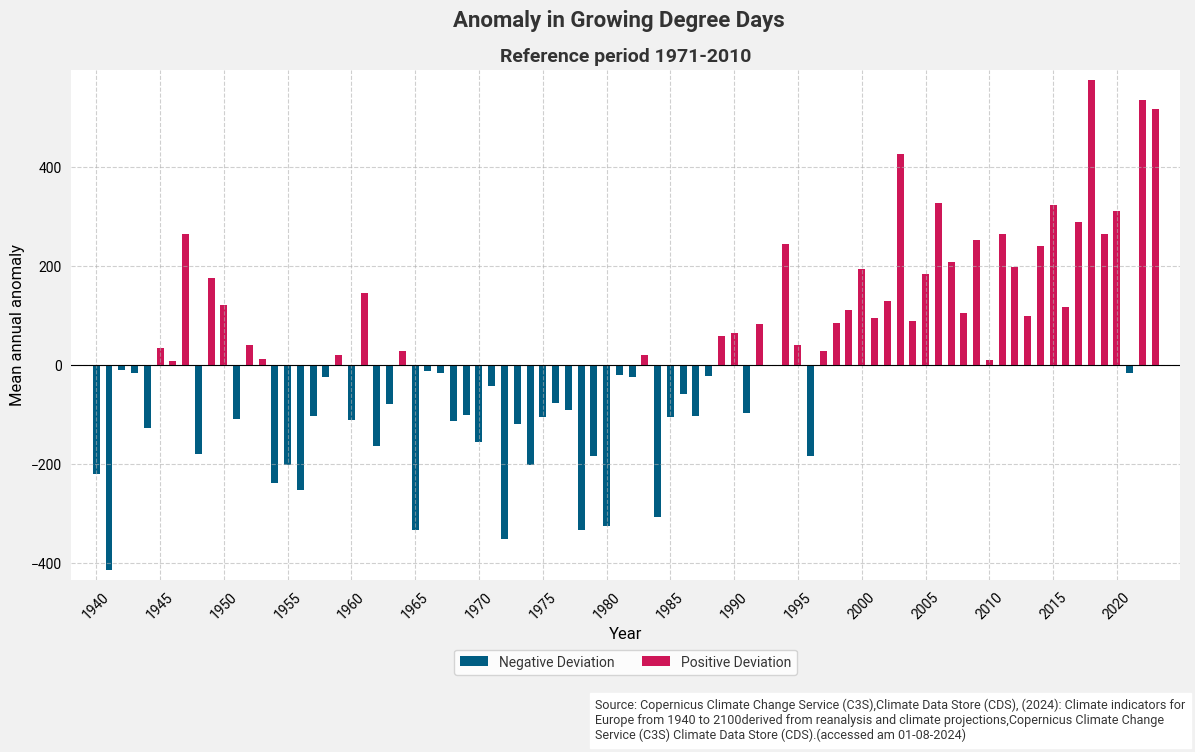

In [21]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Plot negative values
ax.bar(df_reanalysis_yearly_mean['time'][df_reanalysis_yearly_mean['anomaly'] < 0], 
       df_reanalysis_yearly_mean['anomaly'][df_reanalysis_yearly_mean['anomaly'] < 0], 
       width=200,
       color=color_rcp4_5,
       label='Negative Deviation')

# Plot positive values
ax.bar(df_reanalysis_yearly_mean['time'][df_reanalysis_yearly_mean['anomaly'] >= 0], 
       df_reanalysis_yearly_mean['anomaly'][df_reanalysis_yearly_mean['anomaly'] >= 0], 
       width=200,
       color=color_rcp8_5,
       label='Positive Deviation')

# Add a zero line
ax.axhline(0, color='black', linewidth=0.8)

# Set axis labels and chart title
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Mean annual anomaly", fontsize=12)
ax.set_title(f"Reference period {start_year}-{end_year}", fontsize=14, fontweight='bold')
fig.suptitle(f"Anomaly in {selected_ds_variable.value.replace('_',' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Add grid to the plot
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)

# X-axis: Show all 5-year intervals
years = pd.date_range(start=df_reanalysis_yearly_mean['time'].min(),
                      end=df_reanalysis_yearly_mean['time'].max(),
                      freq='5YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Add description
plt.figtext(
    0.5,
    -0.035,
    (
       'Source: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Climate indicators for Europe from 1940 to 2100'
       'derived from reanalysis and climate projections,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(accessed am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 5.6 Visualisation of the Annual Mean value with a Trend Line

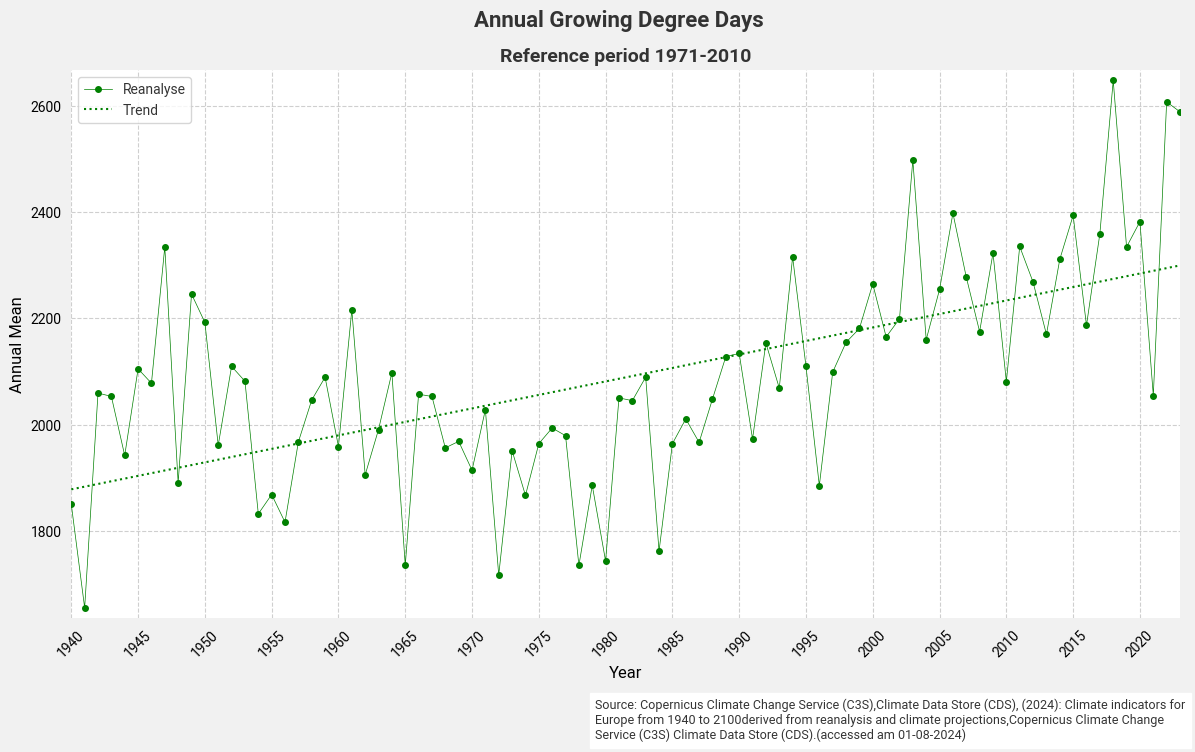

In [22]:
import numpy as np

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Plot the time series
plt.plot(df_reanalysis_yearly_mean['time'],
         df_reanalysis_yearly_mean[variable_name_reanalysis],
         **design_reanalyse)

# Plot the Trend line
z = np.polyfit(df_reanalysis_yearly_mean['time'].dt.year,
               df_reanalysis_yearly_mean[variable_name_reanalysis], 1)
p = np.poly1d(z)
ax.plot(df_reanalysis_yearly_mean['time'],
        p(df_reanalysis_yearly_mean['time'].dt.year),
        label='Trend',
        color=color_reanalyse,
        linestyle=":",
        linewidth=1.5)

# Set axis labels and chart title
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Annual Mean", fontsize=12)
ax.set_title(f"Reference period {start_year}-{end_year}", fontsize=14, fontweight='bold')

# Set plot title
fig.suptitle(f"Annual {selected_ds_variable.value.replace('_',' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Set limit of the X-axis
plt.xlim(df_reanalysis_yearly_mean['time'].min(), df_reanalysis_yearly_mean['time'].max())

# Add grid to the plot
ax.grid(visible=True,
        color='#b0b0b0',
        linestyle='--',
        linewidth=0.8,
        alpha=0.6)

# X-axis: Show all 5-year intervals
years = pd.date_range(start=df_reanalysis_yearly_mean['time'].min(),
                      end=df_reanalysis_yearly_mean['time'].max(),
                      freq='5YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Add Description
plt.figtext(
    0.5,
    -0.035,
    (
       'Source: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Climate indicators for Europe from 1940 to 2100'
       'derived from reanalysis and climate projections,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(accessed am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Add legend
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 5.7 Preparation of reanalysis and projection data for Visualisation

In [23]:
def compute_projection_data(start_year, intermediate_year, end_year):
    # Extract the variable data from the NetCDF files
    variable_name_reanalysis = nc_file_reanalysis['variable_name']
    df_reanalysis = netcdf_to_dataframe(nc_file=nc_file_reanalysis,
                                        bounding_box=bbox_wgs84_konstanz_standard).reset_index()
    
    variable_name_projections = nc_file_proj_rcp45['variable_name']
    df_rcp45 = netcdf_to_dataframe(nc_file=nc_file_proj_rcp45,
                                   bounding_box=bbox_wgs84_konstanz_standard).reset_index()
    df_rcp85 = netcdf_to_dataframe(nc_file=nc_file_proj_rcp85,
                                   bounding_box=bbox_wgs84_konstanz_standard).reset_index()

    # Convert the time column into datetime format
    df_reanalysis['time'] = pd.to_datetime(df_reanalysis['time'])
    df_rcp45['time'] = pd.to_datetime(df_rcp45['time'])
    df_rcp85['time'] = pd.to_datetime(df_rcp85['time'])

    # Filter the data records based on the specified time periods
    df_reanalysis = df_reanalysis[(df_reanalysis['time'].dt.year >= start_year) & 
                                  (df_reanalysis['time'].dt.year <= intermediate_year)]
    df_rcp45 = df_rcp45[(df_rcp45['time'].dt.year >= intermediate_year + 1) & 
                        (df_rcp45['time'].dt.year <= end_year)]
    df_rcp85 = df_rcp85[(df_rcp85['time'].dt.year >= intermediate_year + 1) &
                        (df_rcp85['time'].dt.year <= end_year)]

    # Add the "Year" column to the projection data for easier aggregation
    df_rcp45['Year'] = df_rcp45['time'].dt.year
    df_rcp85['Year'] = df_rcp85['time'].dt.year

    # Calculate 30-year moving average for both scenarios
    df_rcp45 = compute_fixed_30_year_average(df_rcp45, variable_name_projections)
    df_rcp85 = compute_fixed_30_year_average(df_rcp85, variable_name_projections)

    return variable_name_reanalysis, df_reanalysis, variable_name_projections, df_rcp45, df_rcp85

def compute_fixed_30_year_average(df, column):
    # Ensure that the data is sorted by "year" before calculating the statistics
    df = df.sort_values(by='Year')
    
    # Calculate the 30-year moving average and standard deviation (Centered window)
    df['30_year_avg'] = df[column].rolling(window=30, min_periods=1, center=True).mean()
    df['30_year_std'] = df[column].rolling(window=30, min_periods=1, center=True).std()
    
    return df

# Define the year range
start_year = 1940
intermediate_year = 2023
end_year = 2100

variable_name_reanalysis, df_reanalysis, variable_name_projections, df_rcp45, df_rcp85 = compute_projection_data(start_year,intermediate_year, end_year)

### 5.8 Visualisation of Annual Mean values of the reanalysis and climate projection data (RCP4.5 and RCP8.5) with a trend line

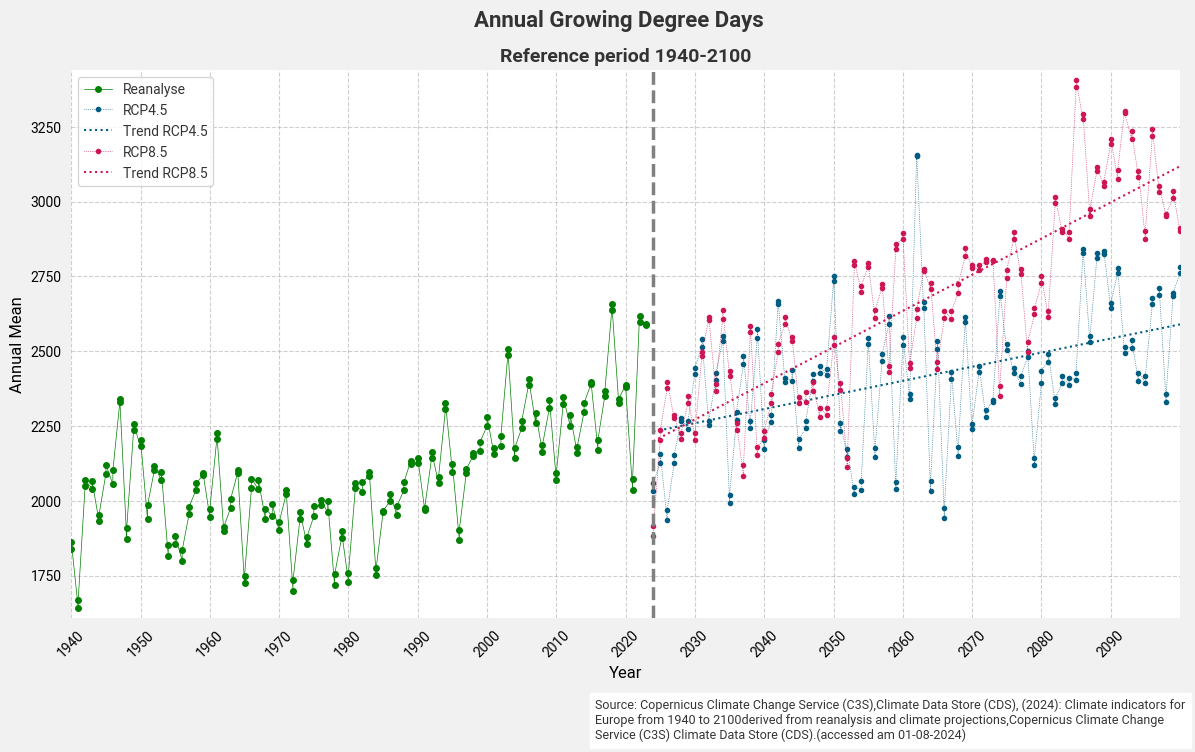

In [24]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Plot Reanalyse Data
plt.plot(df_reanalysis['time'],
         df_reanalysis[variable_name_reanalysis],
         **design_reanalyse)

# Plot RCP4.5 Scenario Data and Trend line
plt.plot(df_rcp45['time'],
         df_rcp45[variable_name_projections],
         **design_rcp45)

# Calculate linear trend line for the RCP4.5 scenario
z = np.polyfit(df_rcp45['time'].dt.year, df_rcp45[variable_name_projections], 1)
p = np.poly1d(z)

# Plot Trend line for RCP4.5 Scenario Data
plt.plot(df_rcp45['time'],
         p(df_rcp45['time'].dt.year),
         **design_rcp45_trend)

# Plot RCP8.5 Scenario Data and Trend line
plt.plot(df_rcp85['time'],
         df_rcp85[variable_name_projections],
         **design_rcp85)

# Calculate linear trend line for the RCP8.5 scenario
z = np.polyfit(df_rcp85['time'].dt.year, df_rcp85[variable_name_projections], 1)
p = np.poly1d(z)

# Plot Trend line for RCP8.5 Scenario Data
plt.plot(df_rcp85['time'],
         p(df_rcp85['time'].dt.year),
         **design_rcp85_trend)

# Add vertical dividing line to distinguish between historical data and projections
plt.axvline(x=pd.Timestamp('2024-01-01'), **design_trennlinie)

# Set axis labels and chart title
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Annual Mean", fontsize=12)
ax.set_title(f"Reference period {start_year}-{end_year}", fontsize=14, fontweight='bold')

# Set plot title
fig.suptitle(f"Annual {selected_ds_variable.value.replace('_', ' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Set limit of the X-axis
plt.xlim(df_reanalysis['time'].min(), df_rcp45['time'].max())

# Add grid to the plot
ax.grid(visible=True,
        color='#b0b0b0',
        linestyle='--',
        linewidth=0.8,
        alpha=0.6)

# X-axis: Show all 10-year intervals
years = pd.date_range(start=df_reanalysis['time'].min(),
                      end=df_rcp45['time'].max(),
                      freq='10YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Add Description
plt.figtext(
    0.5,
    -0.035,
    (
       'Source: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Climate indicators for Europe from 1940 to 2100'
       'derived from reanalysis and climate projections,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(accessed am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Add legend
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 5.9 Visualization of Annual Means of reanalysis and climate projection data (RCP4.5 and RCP8.5) with Standard Deviation

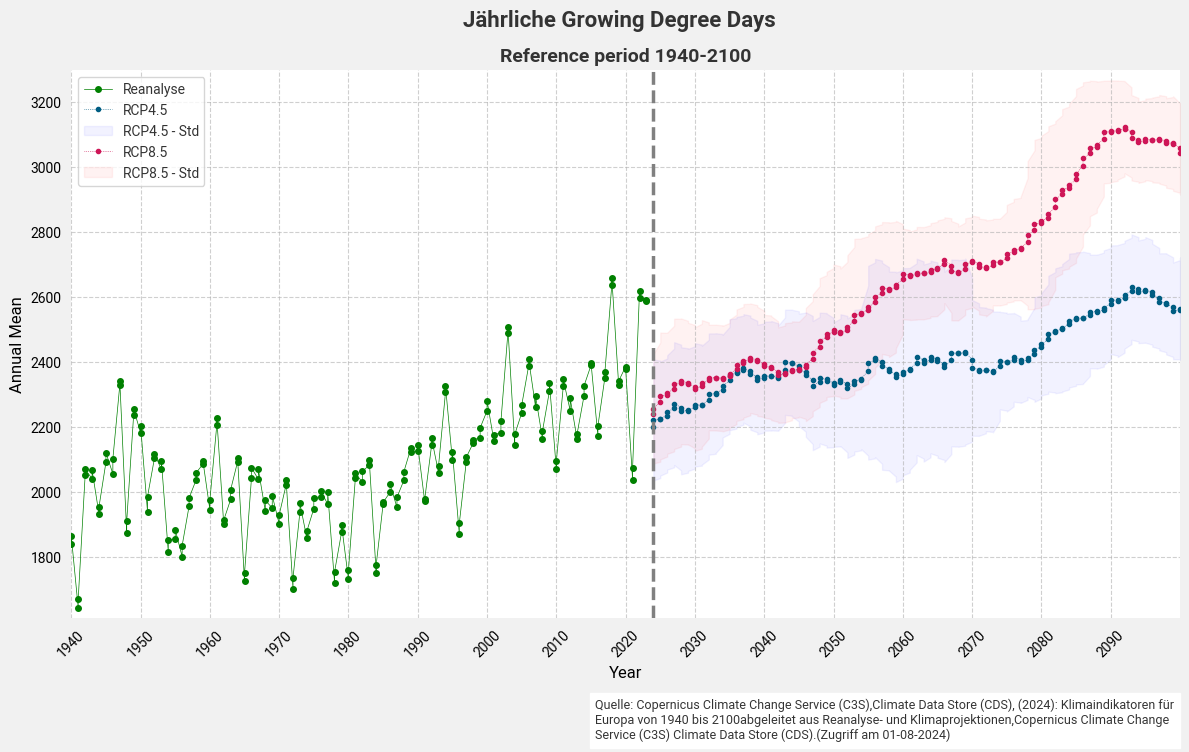

In [25]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Plot Reanalyse Data
plt.plot(df_reanalysis['time'],
         df_reanalysis[variable_name_reanalysis],
         **design_reanalyse)

# Plot RCP4.5 Scenario Data (30-jähriger Durchschnitt)
plt.plot(df_rcp45['time'], df_rcp45['30_year_avg'], **design_rcp45)

# Add uncertainty range for RCP4.5 (±1 Standard Eeviation)
plt.fill_between(df_rcp45['time'], 
                 df_rcp45['30_year_avg'] - df_rcp45['30_year_std'], 
                 df_rcp45['30_year_avg'] + df_rcp45['30_year_std'], 
                 color='blue', alpha=0.05, label='RCP4.5 - Std')

# Plot RCP8.5 Scenario Data (30-jähriger Durchschnitt)
plt.plot(df_rcp85['time'], df_rcp85['30_year_avg'], **design_rcp85)

# Add uncertainty range for RCP8.5 (±1 Standard Eeviation)
plt.fill_between(df_rcp85['time'], 
                 df_rcp85['30_year_avg'] - df_rcp85['30_year_std'], 
                 df_rcp85['30_year_avg'] + df_rcp85['30_year_std'], 
                 color='red', alpha=0.05, label='RCP8.5 - Std')

# Add vertical dividing line to distinguish between historical data and projections
plt.axvline(x=pd.Timestamp('2024-01-01'), **design_trennlinie)

# Set axis labels and chart title
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Annual Mean", fontsize=12)
ax.set_title(f"Reference period {start_year}-{end_year}", fontsize=14, fontweight='bold')

# Set plot title
fig.suptitle(f"Jährliche {selected_ds_variable.value.replace('_', ' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Set limit of the X-axis
plt.xlim(df_reanalysis['time'].min(), df_rcp45['time'].max())

# Add grid to the plot
ax.grid(visible=True,
        color='#b0b0b0',
        linestyle='--',
        linewidth=0.8,
        alpha=0.6)

# X-axis: Show all 10-year intervals
years = pd.date_range(start=df_reanalysis['time'].min(),
                      end=df_rcp45['time'].max(),
                      freq='10YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Add Description
plt.figtext(
    0.5,
    -0.035,
    (
       'Source: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Climate indicators for Europe from 1940 to 2100'
       'derived from reanalysis and climate projections,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(accessed am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Add legend
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
